## Importing

In [24]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import salishsea_tools.viz_tools as sa_vi

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse


## Datasets Preparation

In [25]:
def datasets_preparation ():
    
    temp_i1 = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
               [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]

    temp_i2 = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
               [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

    saline_i1 = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
                 [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]

    saline_i2 = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
                 [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

    sil_i = (ds_bio.silicon.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
             [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    nitr_i = (ds_bio.nitrate.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    ammo_i = (ds_bio.ammonium.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    diat_i = (ds_bio.diatoms.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    flag_i = (ds_bio.flagellates.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]
    
    micro_i = (ds_bio.microzooplankton.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    meso_i = (ds_bio.mesozooplankton.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    return (temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i,  flag_i, micro_i, meso_i)


## MLPRegressor

In [26]:
def regressor (inputs, targets, variable_name):

    # Pre processing 
    indx = np.where(~np.isnan(inputs).any(axis=0))
    inputs2 = inputs[:,indx[0]]
    inputs2 = inputs2.transpose()

    targets2 = targets[indx]
    targets2 = np.ravel(targets2)

    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs2)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
    regr = MLPRegressor(hidden_layer_sizes = 100, activation = 'relu', solver = 'adam', max_iter=1500, random_state=1, learning_rate_init=0.01).fit(X_train, y_train)
    outputs_test = regr.predict(X_test)
    outputs = regr.predict(inputs2)

    scatter_plot(y_test, outputs_test, variable_name + ' (Testing dataset)')

    # Post processing
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[0]] = outputs
    model = np.reshape(indx2,(898,398)) 

    # Preparation of the dataarray 
    model = xr.DataArray(model,
                    coords = {'y': temp_i1.y, 'x': temp_i1.x},
                    dims = ['y','x'],
                    attrs=dict( long_name = variable_name + " Concentration",
                                units="mmol m-2"),
                        )

    return (targets2, outputs, model, regr)

# Printing

In [27]:
def printing (targets, outputs, m):

    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(r2_score(targets, outputs),3))
    print (' The mean square error is:', np.round(mse(targets,outputs),3))


## Scatter Plot

In [28]:
def scatter_plot(targets, outputs, variable_name):
    
    fig, ax = plt.subplots()

    plt.scatter(targets,outputs, alpha = 0.2, s = 10)
    plt.xlabel('targets')
    plt.ylabel('outputs')

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # plot fitted y = m*x + b
    plt.axline(xy1=(0, b), slope=m, color='r')

    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(str(date.date[0]) + ', ' + variable_name)

    plt.show()

    printing (targets, outputs, m)


# Plotting

In [29]:
def plotting (targets, outputs, model, variable, variable_name):

    fig, ax = plt.subplots(2,2, figsize = (10,15))

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    variable.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax =targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    model.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    ((variable-model) / variable * 100).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': variable_name + ' Concentration  [percentage]'})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])


    ax[0,0].title.set_text(variable_name + ' (targets)')
    ax[0,1].title.set_text(variable_name + ' (outputs)')
    ax[1,0].title.set_text('targets - outputs')
    ax[1,1].axis('off')

    fig.suptitle(str(date.date[0]))
    

# Summary

In [30]:
def summary(variable, variable_name):

    targets, outputs, model, reg = regressor(drivers, np.ravel(variable), variable_name)
    scatter_plot(targets, outputs, variable_name)
    plotting (targets, outputs, model, variable, variable_name)

    return (reg)

# Summary for Other Days

In [31]:
def summary2(variable, variable_name, reg_variable):

    targets, outputs, model= regressor2(drivers, np.ravel(variable), variable_name, reg_variable)
    scatter_plot(targets, outputs, variable_name)
    plotting (targets, outputs, model, variable, variable_name)

# Regressor for Other Days

In [32]:
def regressor2 (inputs,targets, variable_name, reg_variable):
    
    # Pre processing 
    indx = np.where(~np.isnan(inputs).any(axis=0))
    inputs2 = inputs[:,indx[0]]
    inputs2 = inputs2.transpose()

    targets2 = targets[indx]
    targets2 = np.ravel(targets2)

    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs2)
    outputs = reg_variable.predict(inputs2)

    # Post processing
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[0]] = outputs
    model = np.reshape(indx2,(898,398)) 

    # Preparation of the dataarray 
    model = xr.DataArray(model,
                    coords = {'y': temp_i1.y, 'x': temp_i1.x},
                    dims = ['y','x'],
                    attrs=dict( long_name = variable_name + " Concentration",
                                units="mmol m-2"),
                        )

    return (targets2, outputs, model)

## Main Body

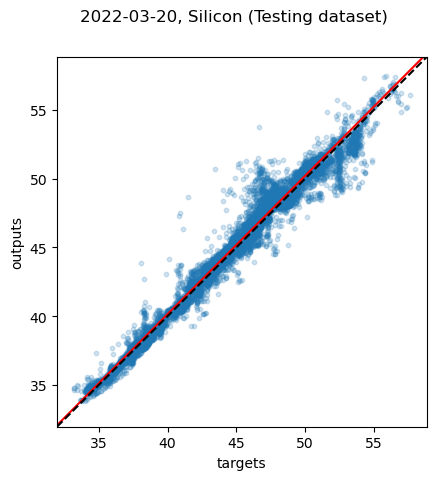

The slope of the best fitting line is  1.006
The correlation coefficient is: 0.976
 The mean square error is: 0.617


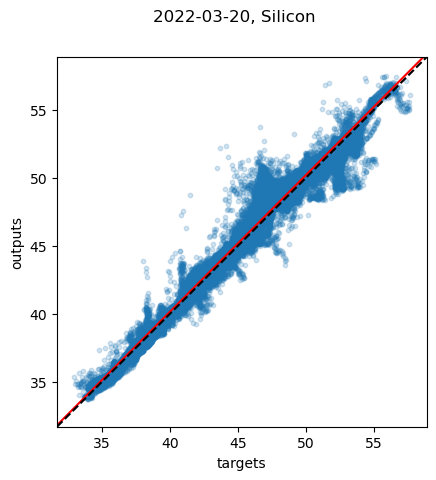

The slope of the best fitting line is  1.005
The correlation coefficient is: 0.977
 The mean square error is: 0.585


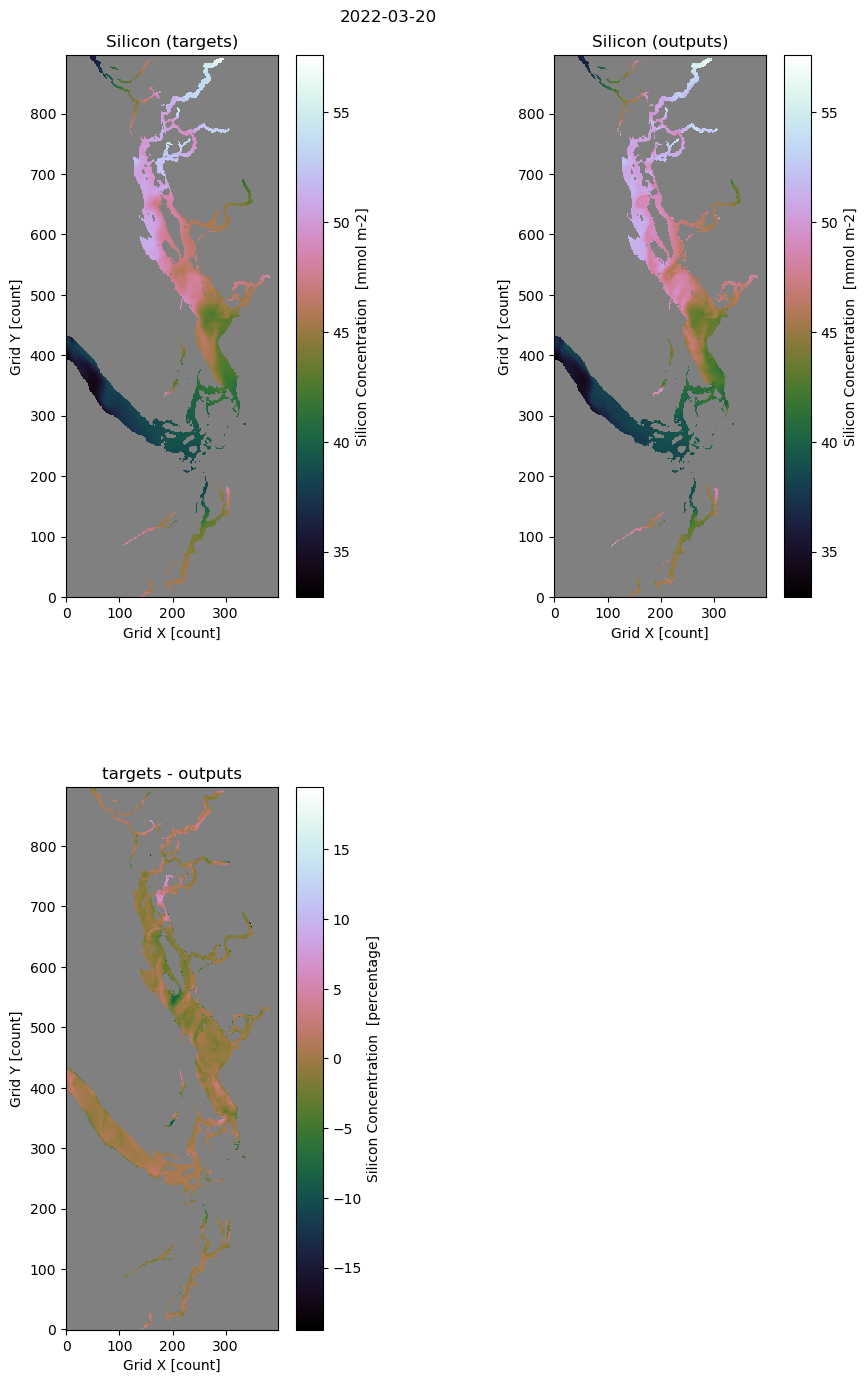

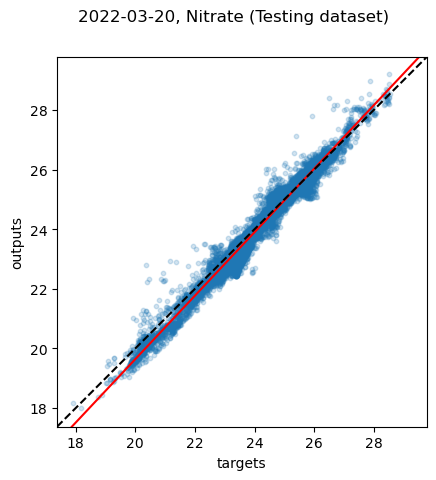

The slope of the best fitting line is  1.065
The correlation coefficient is: 0.96
 The mean square error is: 0.097


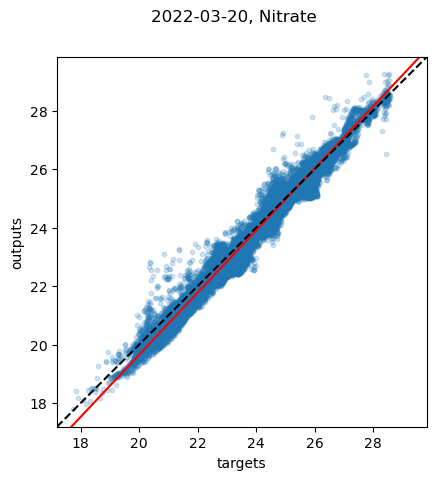

The slope of the best fitting line is  1.062
The correlation coefficient is: 0.963
 The mean square error is: 0.091


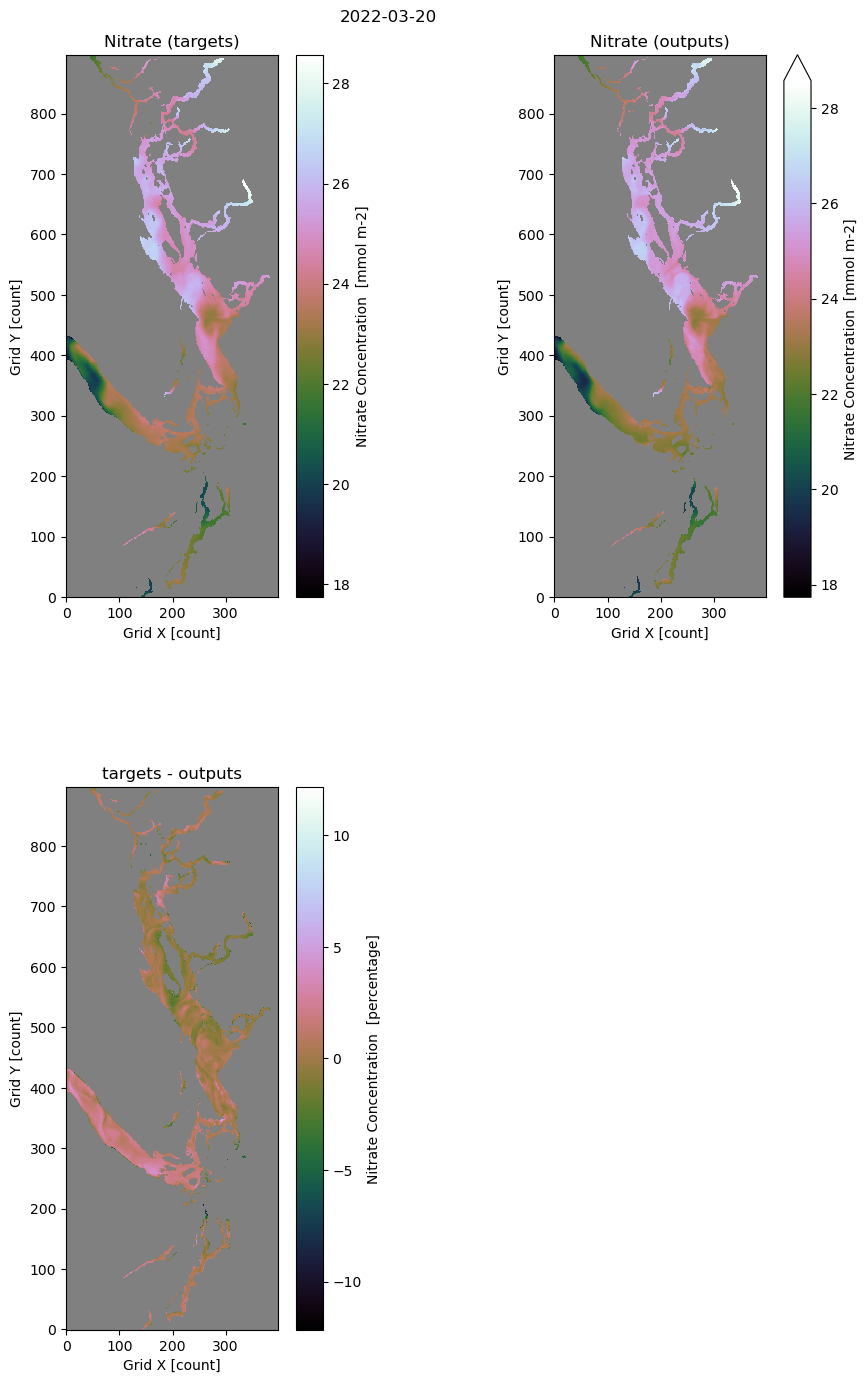

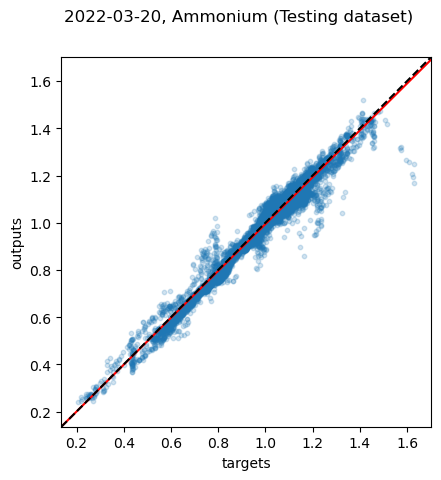

The slope of the best fitting line is  0.993
The correlation coefficient is: 0.965
 The mean square error is: 0.001


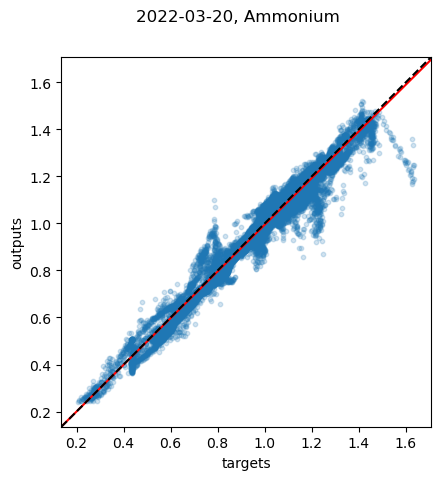

The slope of the best fitting line is  0.993
The correlation coefficient is: 0.965
 The mean square error is: 0.001


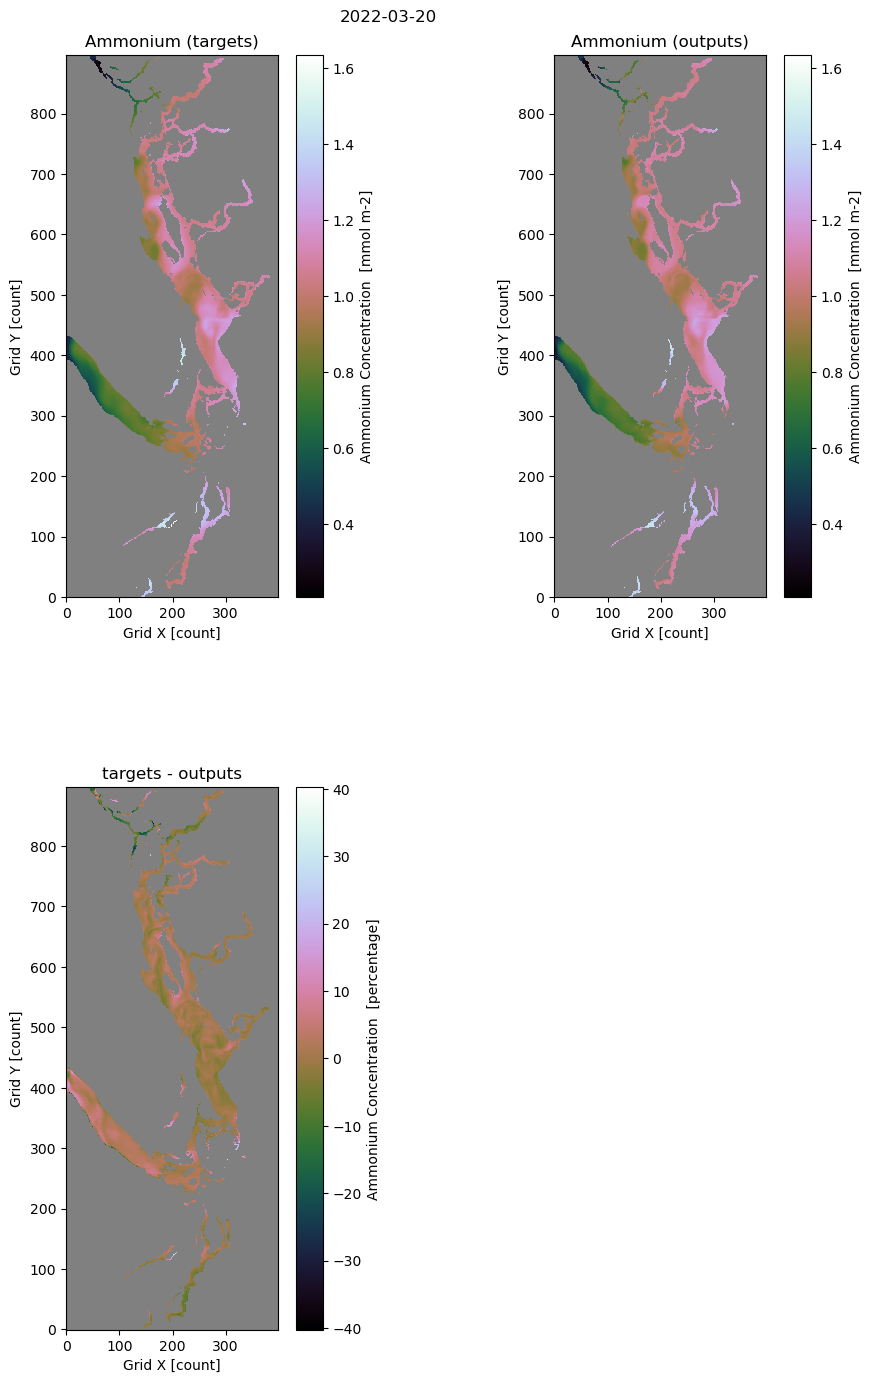

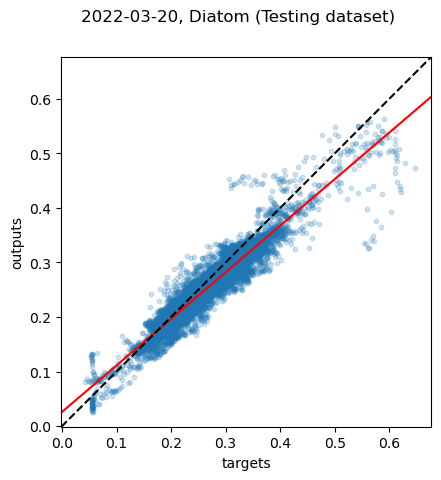

The slope of the best fitting line is  0.854
The correlation coefficient is: 0.876
 The mean square error is: 0.001


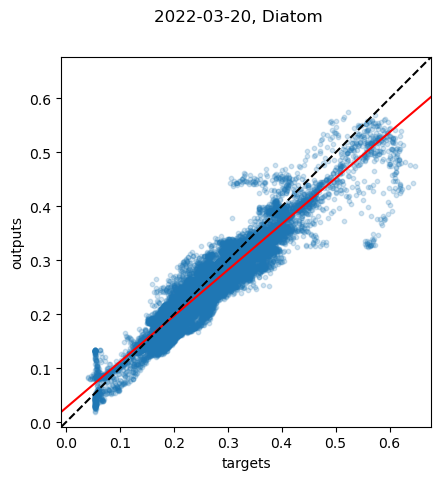

The slope of the best fitting line is  0.852
The correlation coefficient is: 0.878
 The mean square error is: 0.001


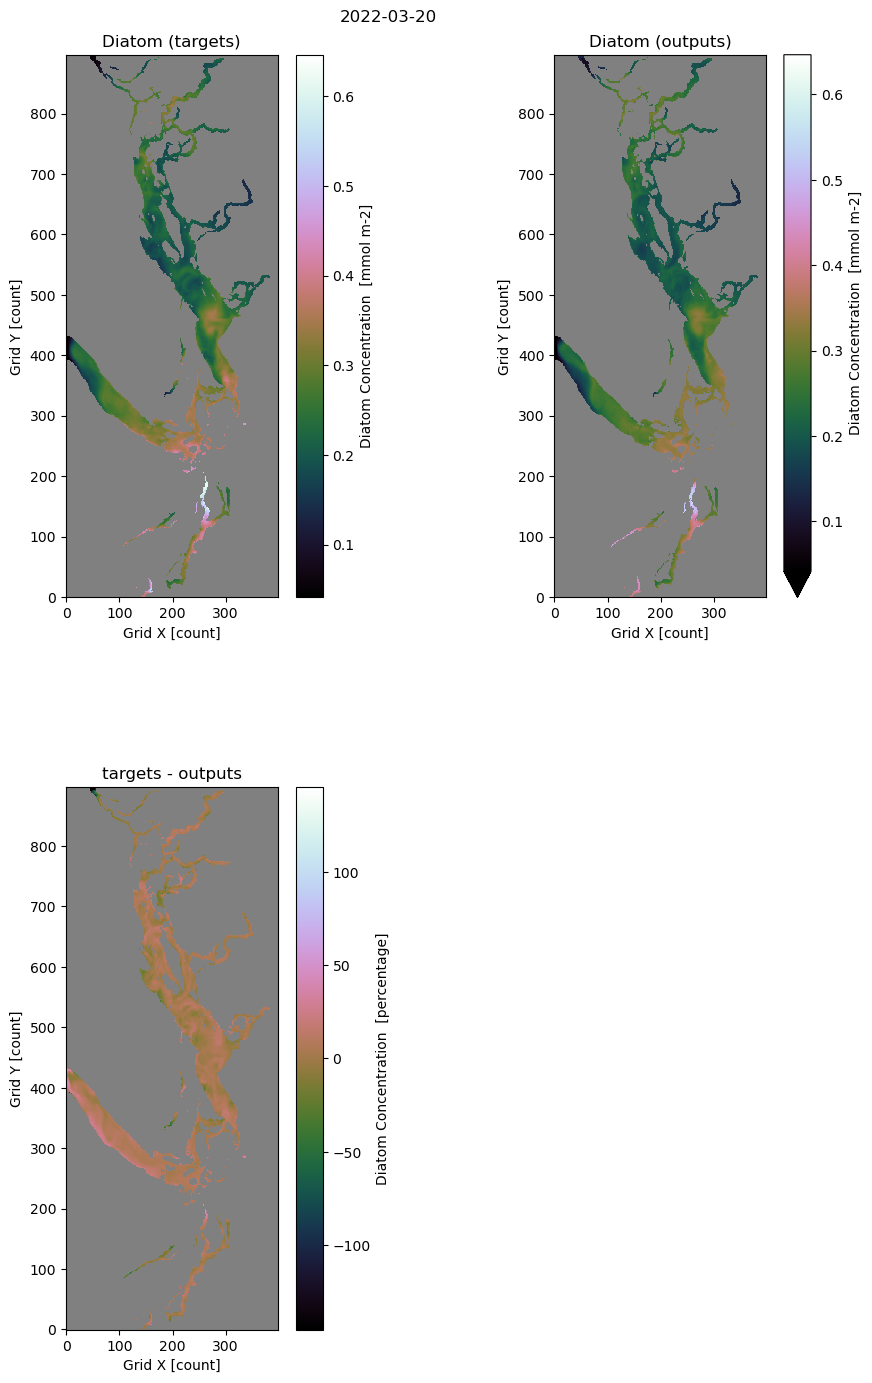

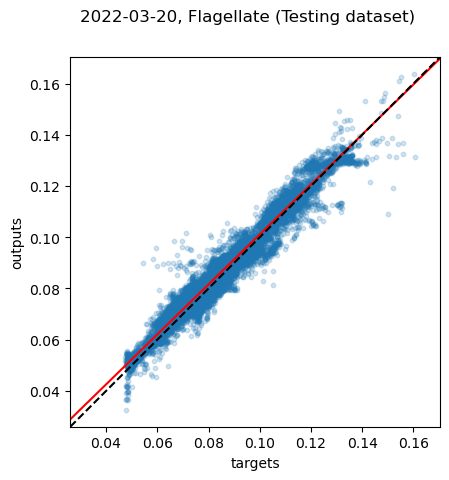

The slope of the best fitting line is  0.976
The correlation coefficient is: 0.951
 The mean square error is: 0.0


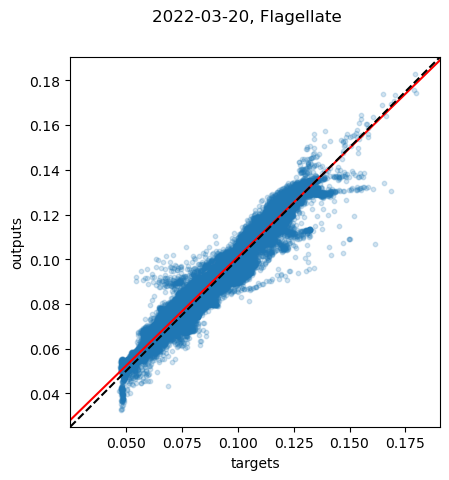

The slope of the best fitting line is  0.973
The correlation coefficient is: 0.95
 The mean square error is: 0.0


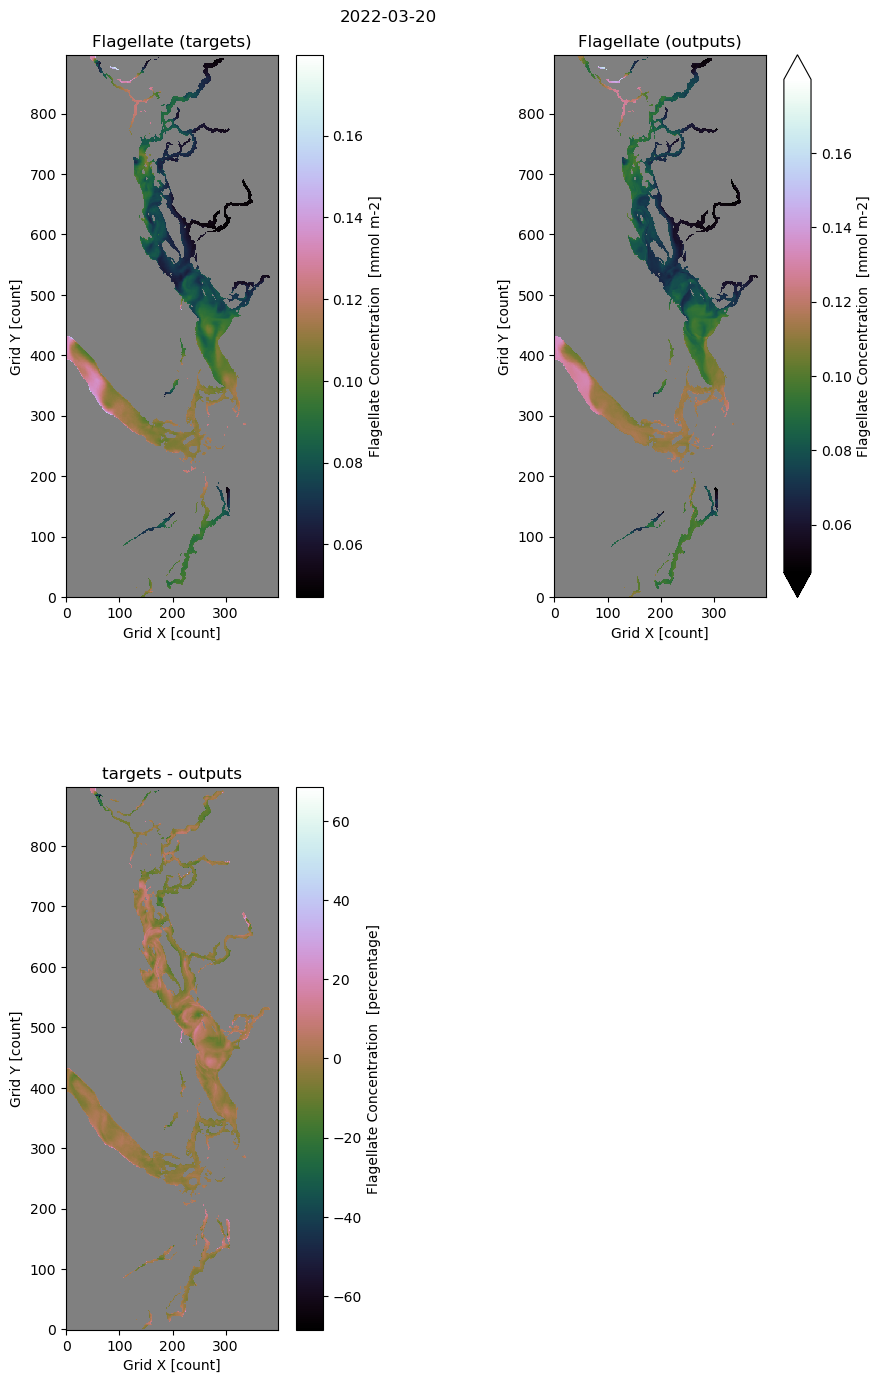

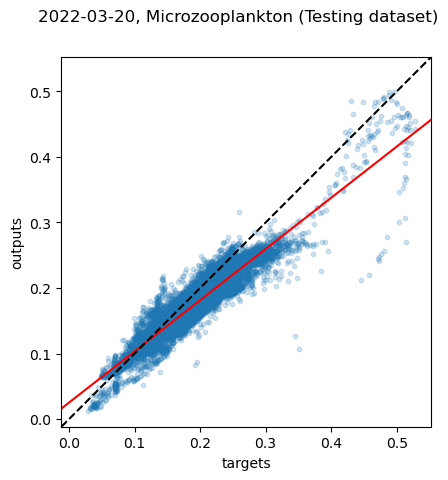

The slope of the best fitting line is  0.781
The correlation coefficient is: 0.79
 The mean square error is: 0.001


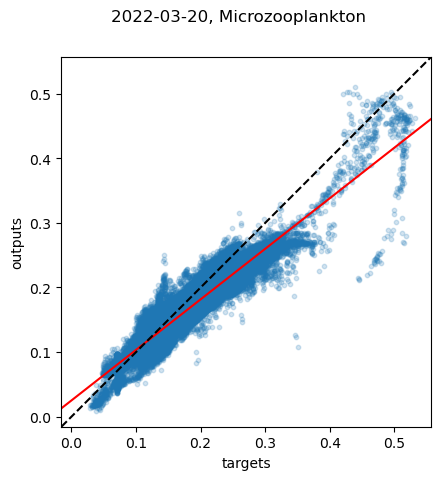

The slope of the best fitting line is  0.783
The correlation coefficient is: 0.797
 The mean square error is: 0.001


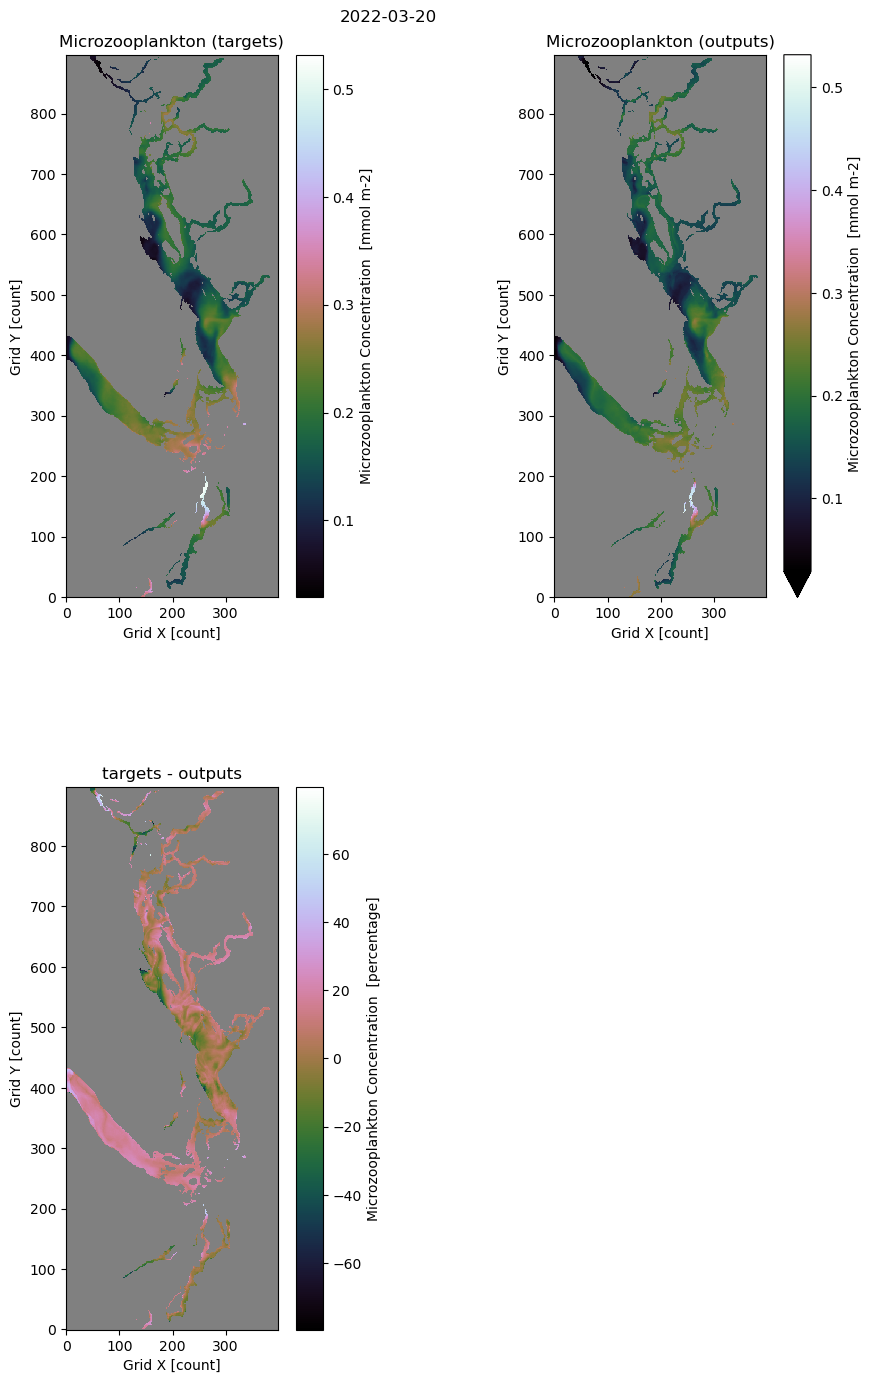

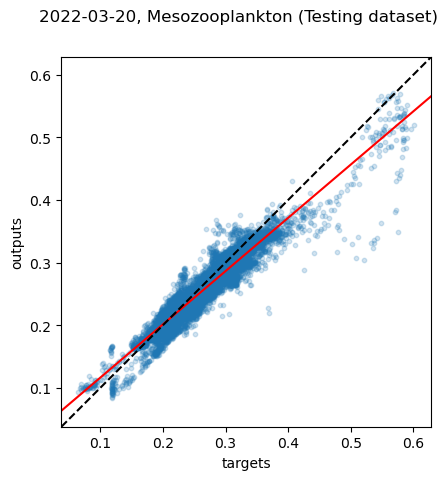

The slope of the best fitting line is  0.851
The correlation coefficient is: 0.883
 The mean square error is: 0.0


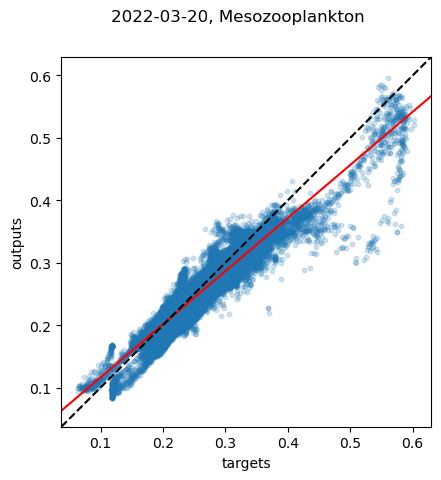

The slope of the best fitting line is  0.851
The correlation coefficient is: 0.887
 The mean square error is: 0.0


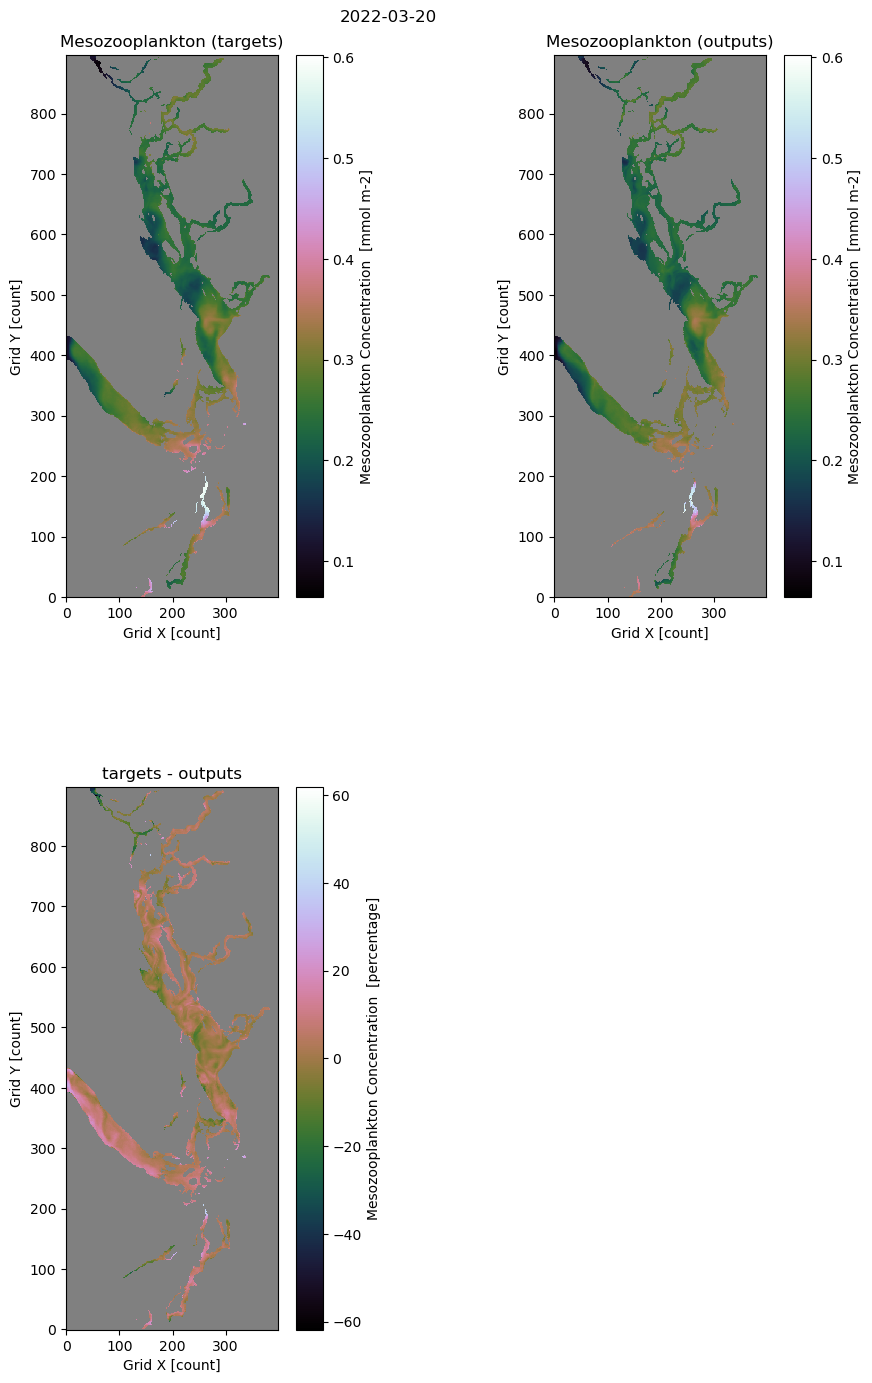

In [33]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i, flag_i, micro_i, meso_i = datasets_preparation()

# Potential input variables
drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
nutrients = np.stack([np.ravel(sil_i), np.ravel(nitr_i), np.ravel(ammo_i)])
phyto = np.stack([np.ravel(diat_i), np.ravel(flag_i)])
zoo = np.stack([np.ravel(micro_i), np.ravel(meso_i)])

reg_sil = summary (sil_i, 'Silicon')
reg_nitr = summary (nitr_i, 'Nitrate')
reg_ammo = summary (ammo_i, 'Ammonium')

reg_diat = summary (diat_i, 'Diatom')
reg_flag = summary (flag_i, 'Flagellate')

reg_mic = summary (micro_i, 'Microzooplankton')
reg_mes = summary (meso_i, 'Mesozooplankton')


# Next Day

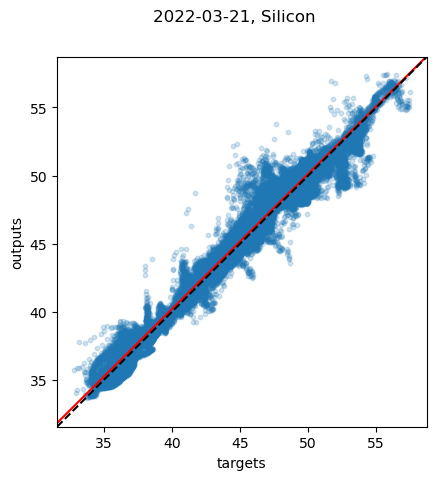

The slope of the best fitting line is  0.992
The correlation coefficient is: 0.972
 The mean square error is: 0.718


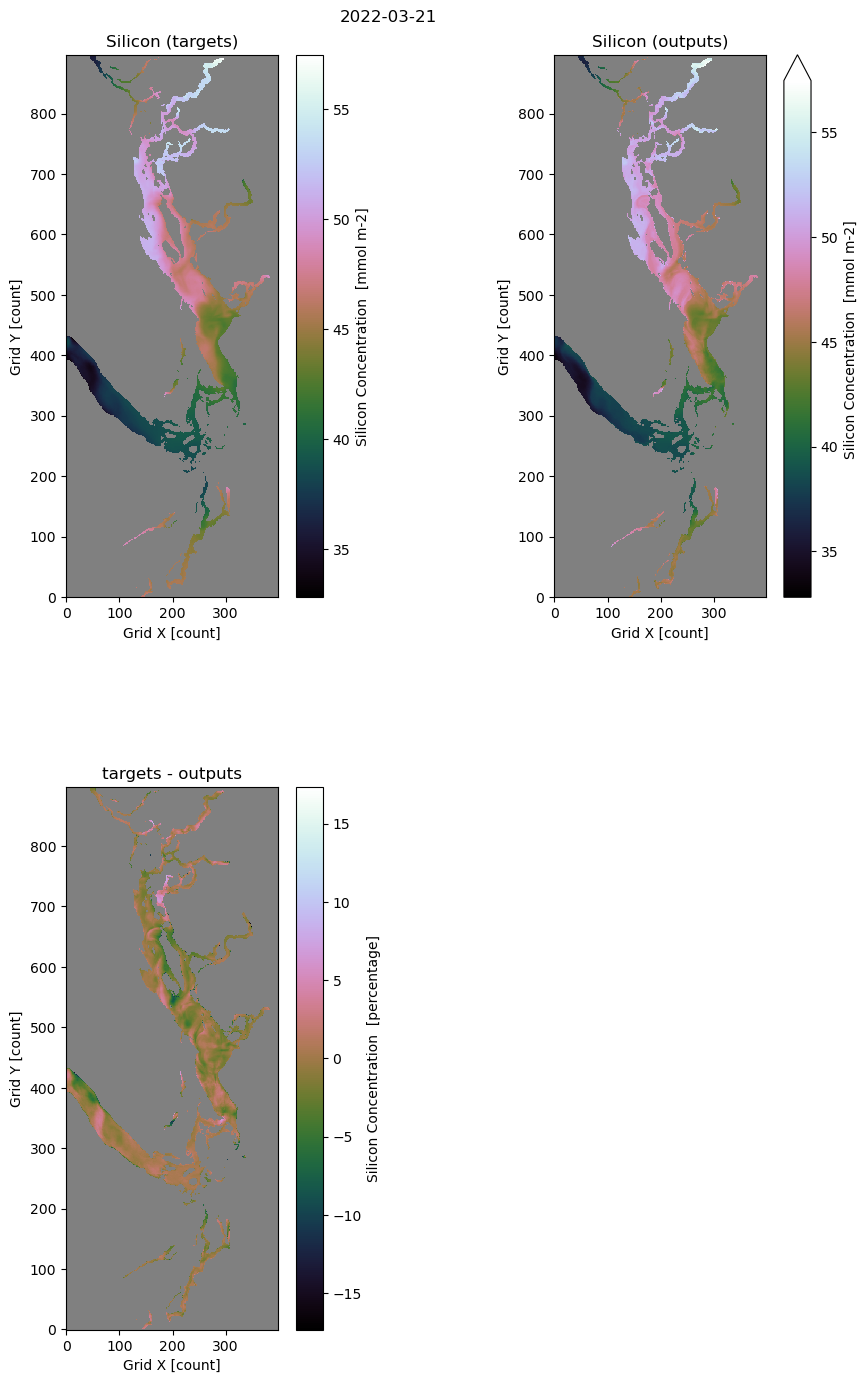

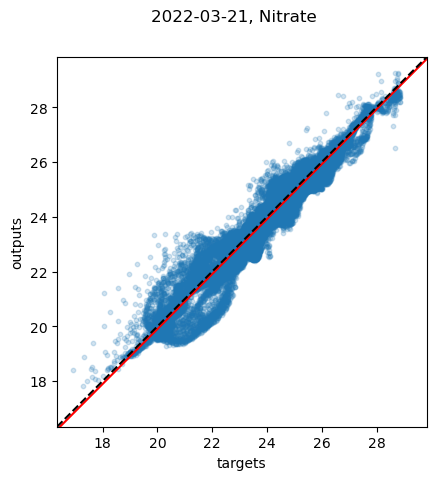

The slope of the best fitting line is  1.003
The correlation coefficient is: 0.929
 The mean square error is: 0.185


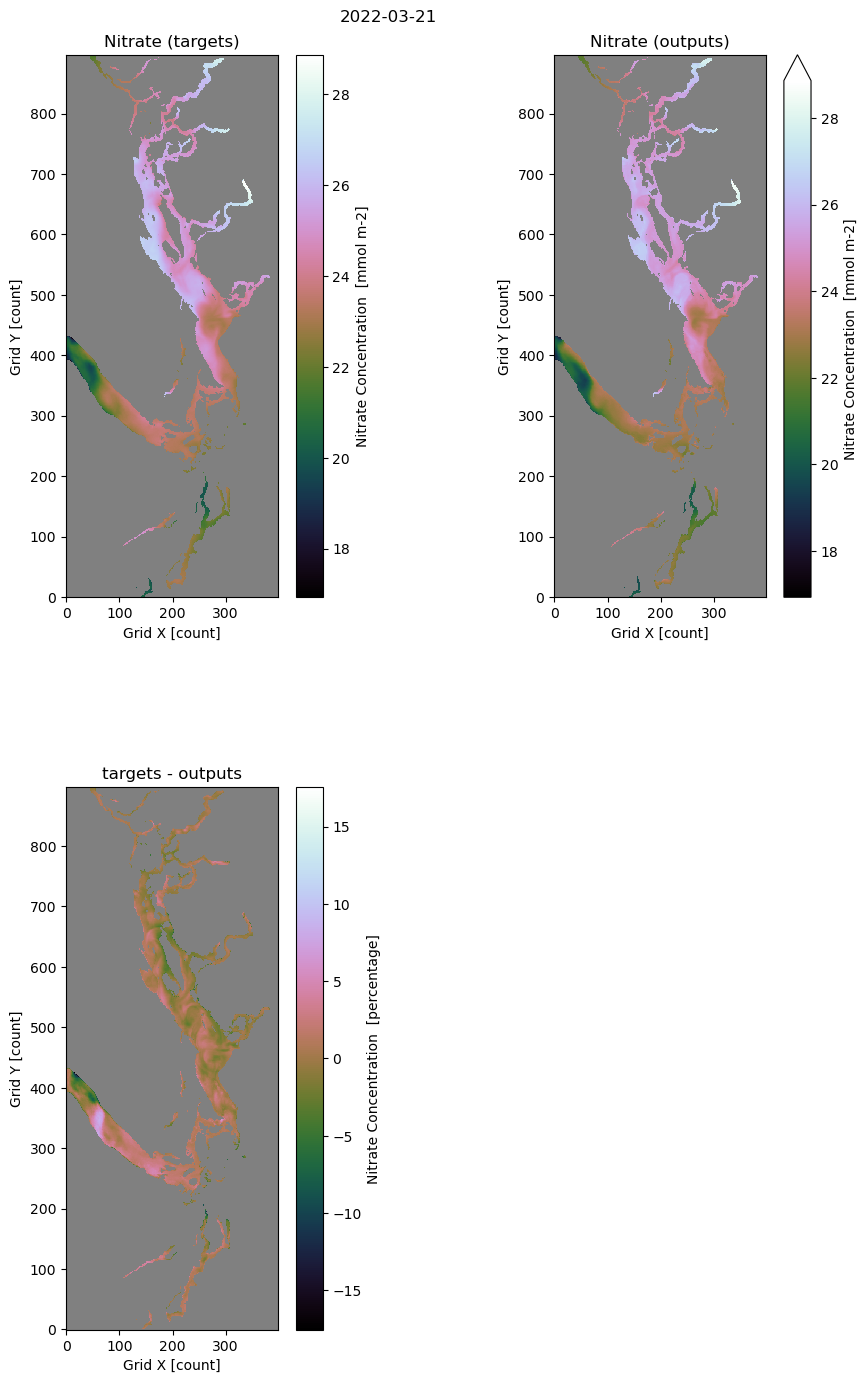

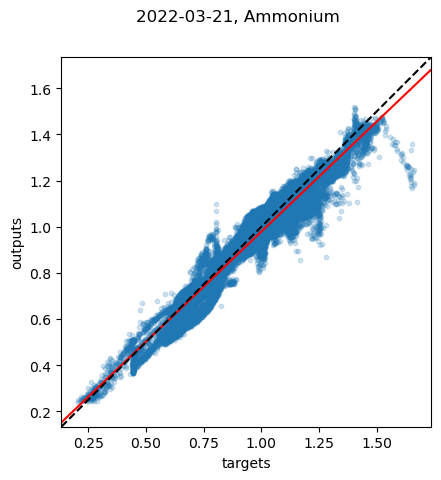

The slope of the best fitting line is  0.954
The correlation coefficient is: 0.93
 The mean square error is: 0.002


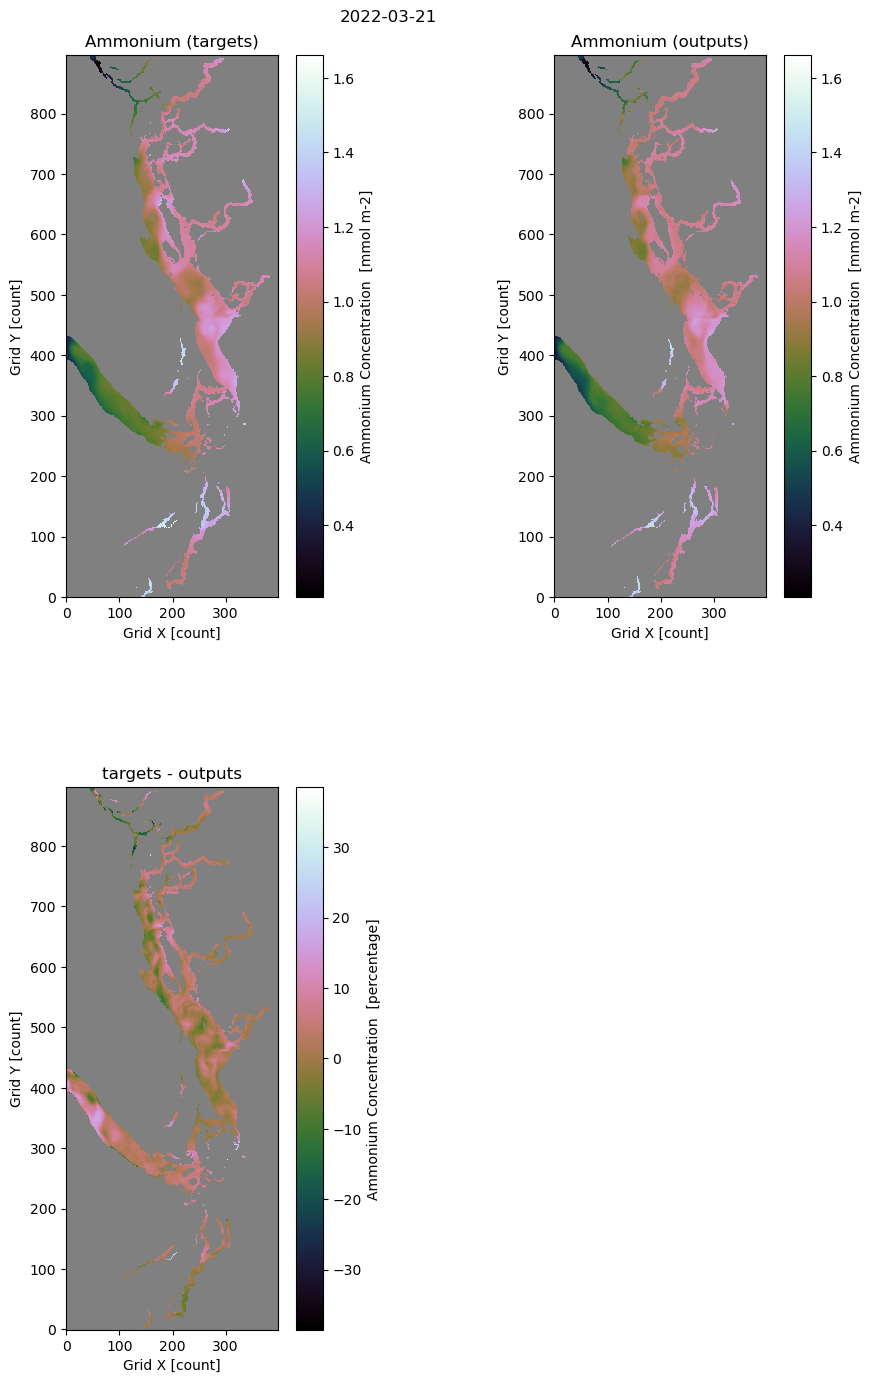

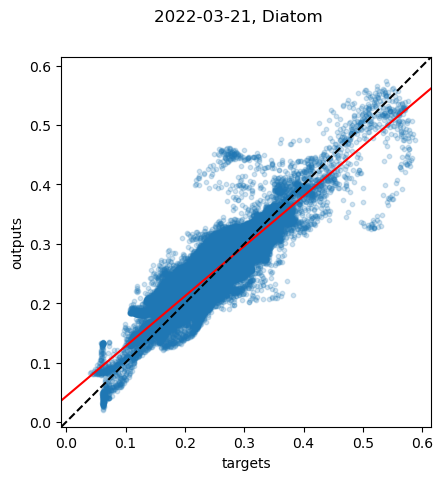

The slope of the best fitting line is  0.844
The correlation coefficient is: 0.829
 The mean square error is: 0.001


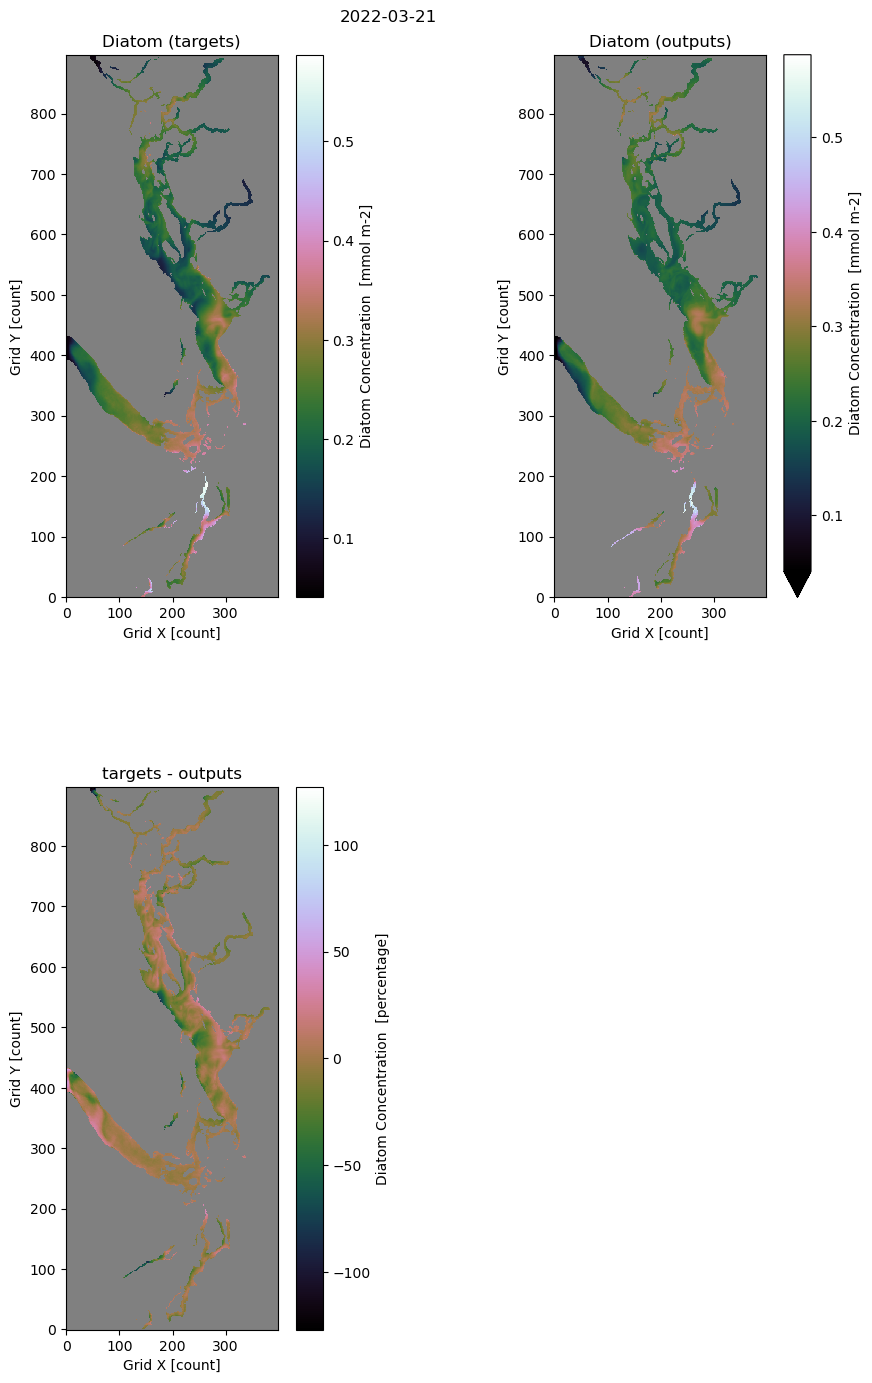

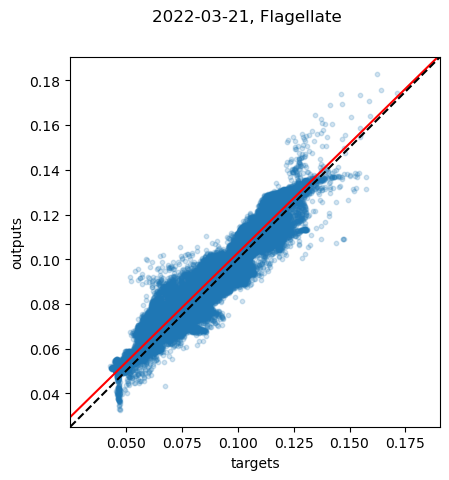

The slope of the best fitting line is  0.979
The correlation coefficient is: 0.9
 The mean square error is: 0.0


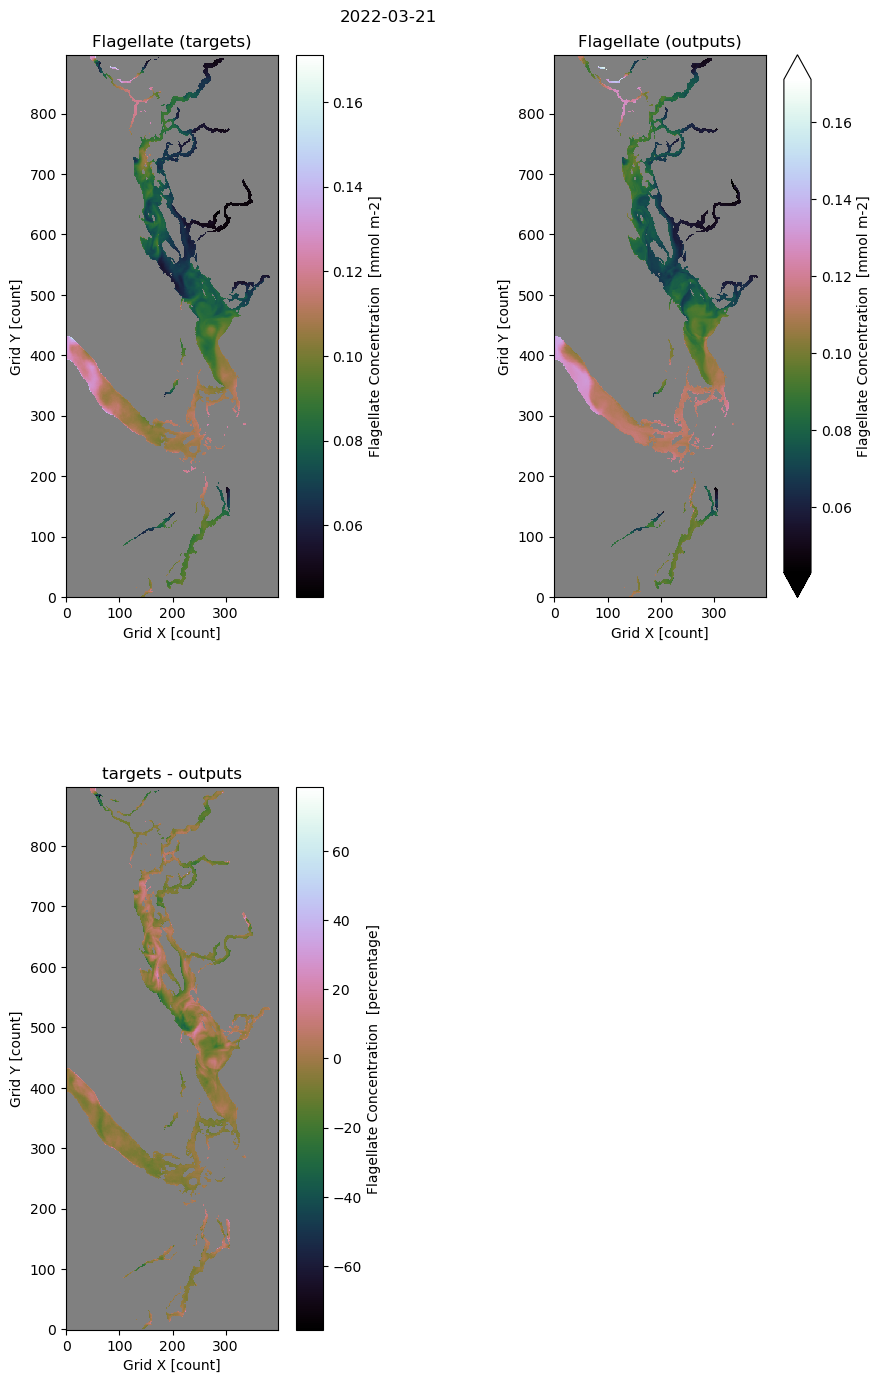

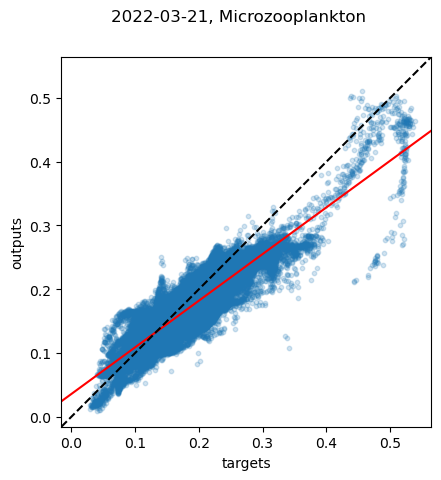

The slope of the best fitting line is  0.732
The correlation coefficient is: 0.753
 The mean square error is: 0.001


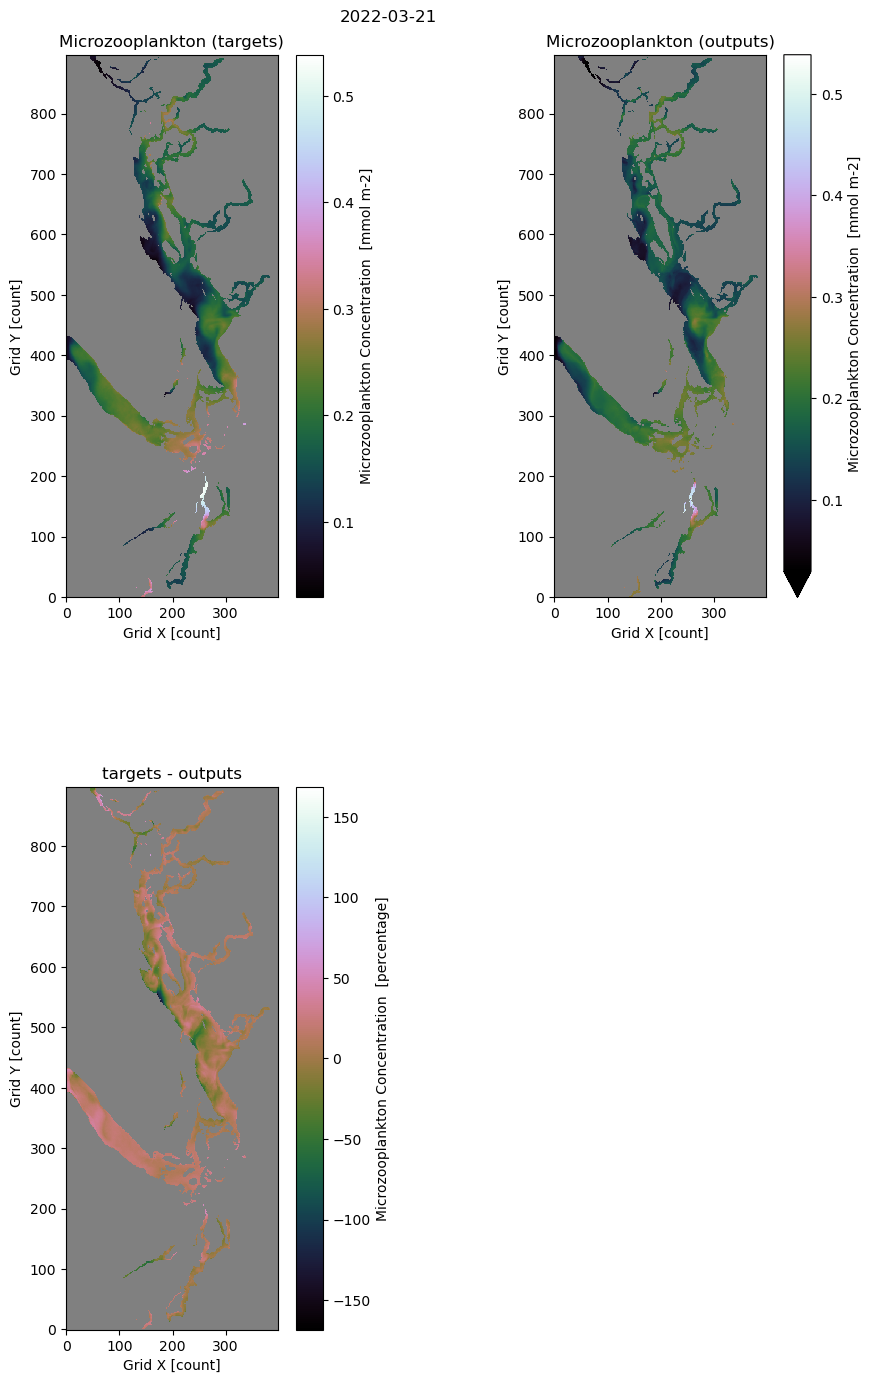

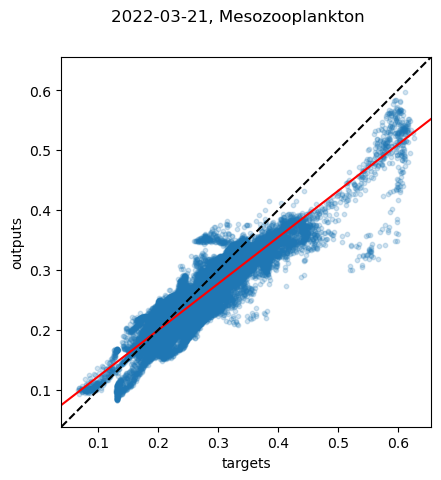

The slope of the best fitting line is  0.774
The correlation coefficient is: 0.778
 The mean square error is: 0.001


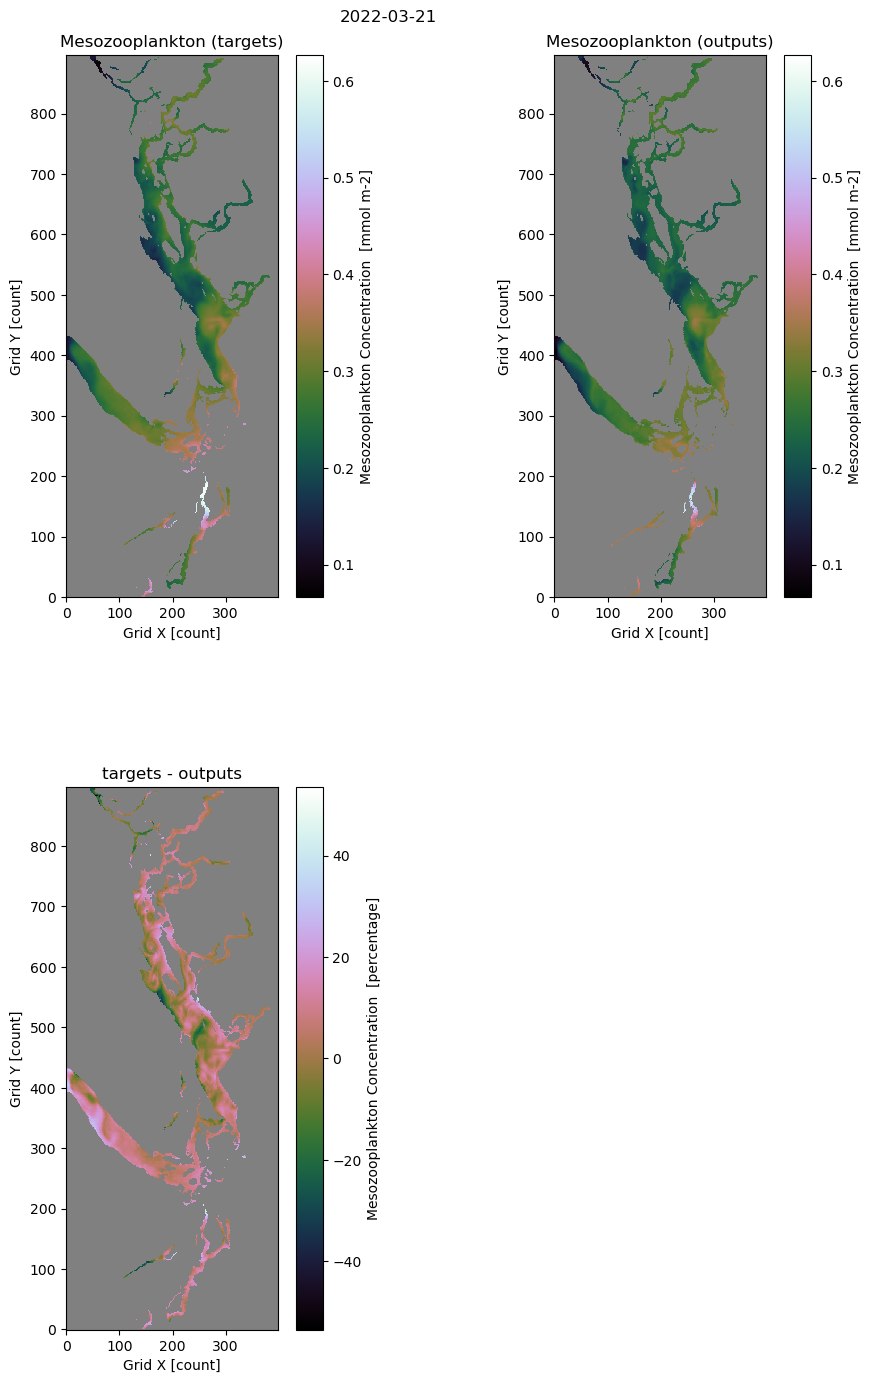

In [34]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/21mar22/SalishSea_1d_20220321_20220321_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/21mar22/SalishSea_1d_20220321_20220321_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i, flag_i, micro_i, meso_i = datasets_preparation()


summary2 (sil_i, 'Silicon', reg_sil)
summary2 (nitr_i, 'Nitrate', reg_nitr)
summary2 (ammo_i, 'Ammonium', reg_ammo)

summary2 (diat_i, 'Diatom', reg_diat)
summary2 (flag_i, 'Flagellate', reg_flag)

summary2 (micro_i, 'Microzooplankton', reg_mic)
summary2 (meso_i, 'Mesozooplankton', reg_mes)



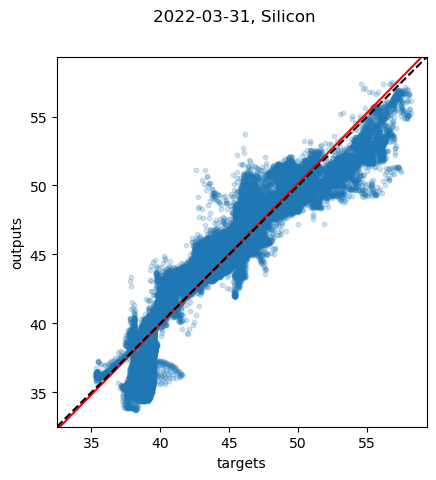

The slope of the best fitting line is  1.022
The correlation coefficient is: 0.89
 The mean square error is: 2.494


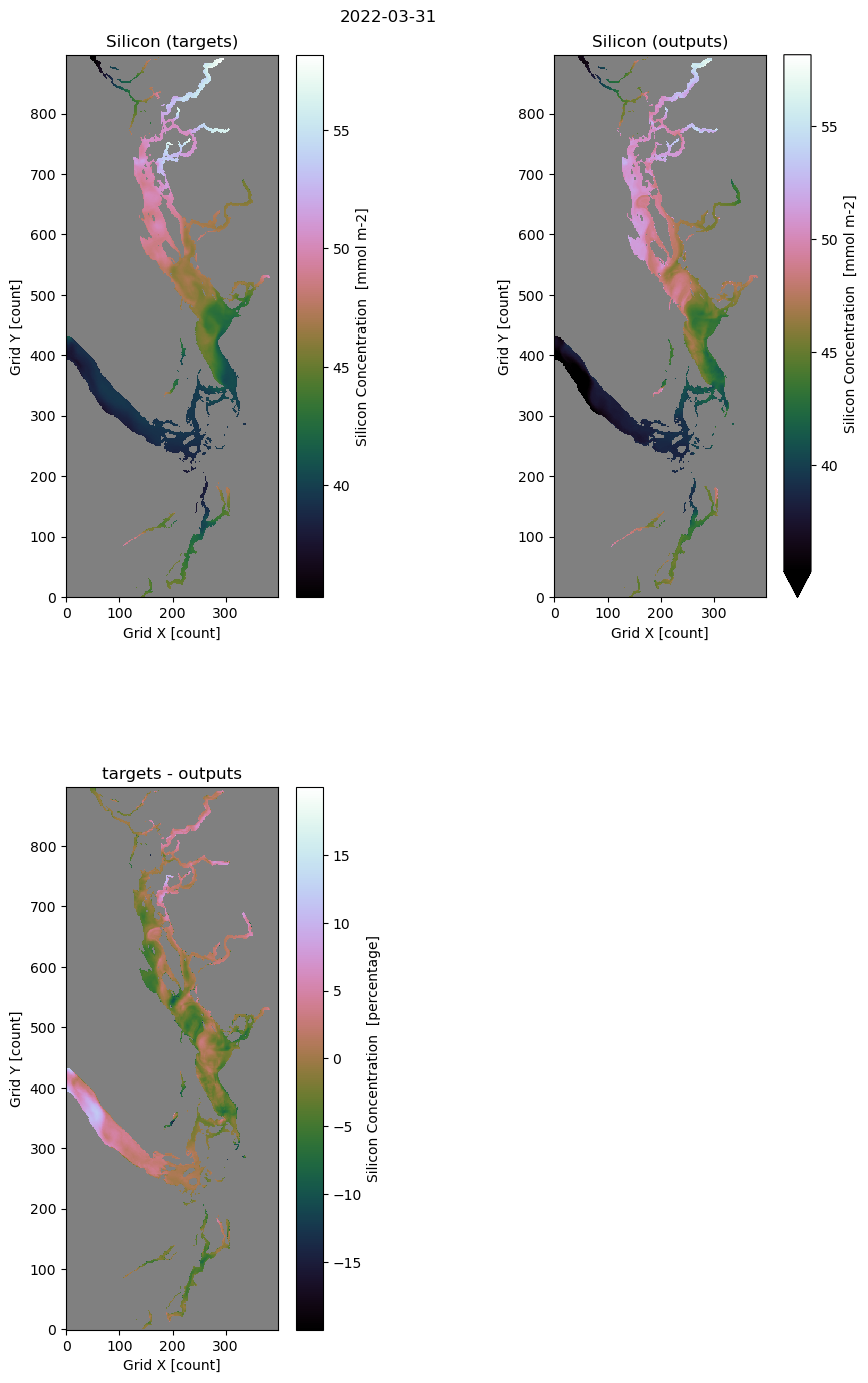

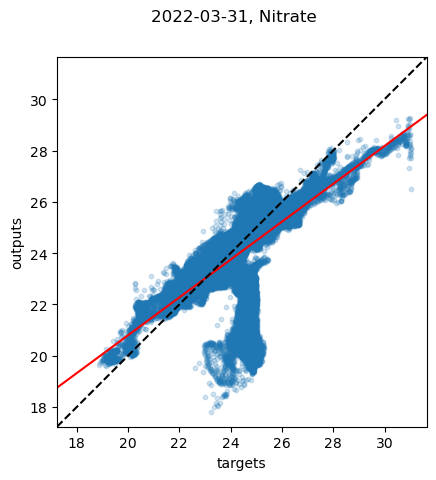

The slope of the best fitting line is  0.738
The correlation coefficient is: 0.143
 The mean square error is: 1.885


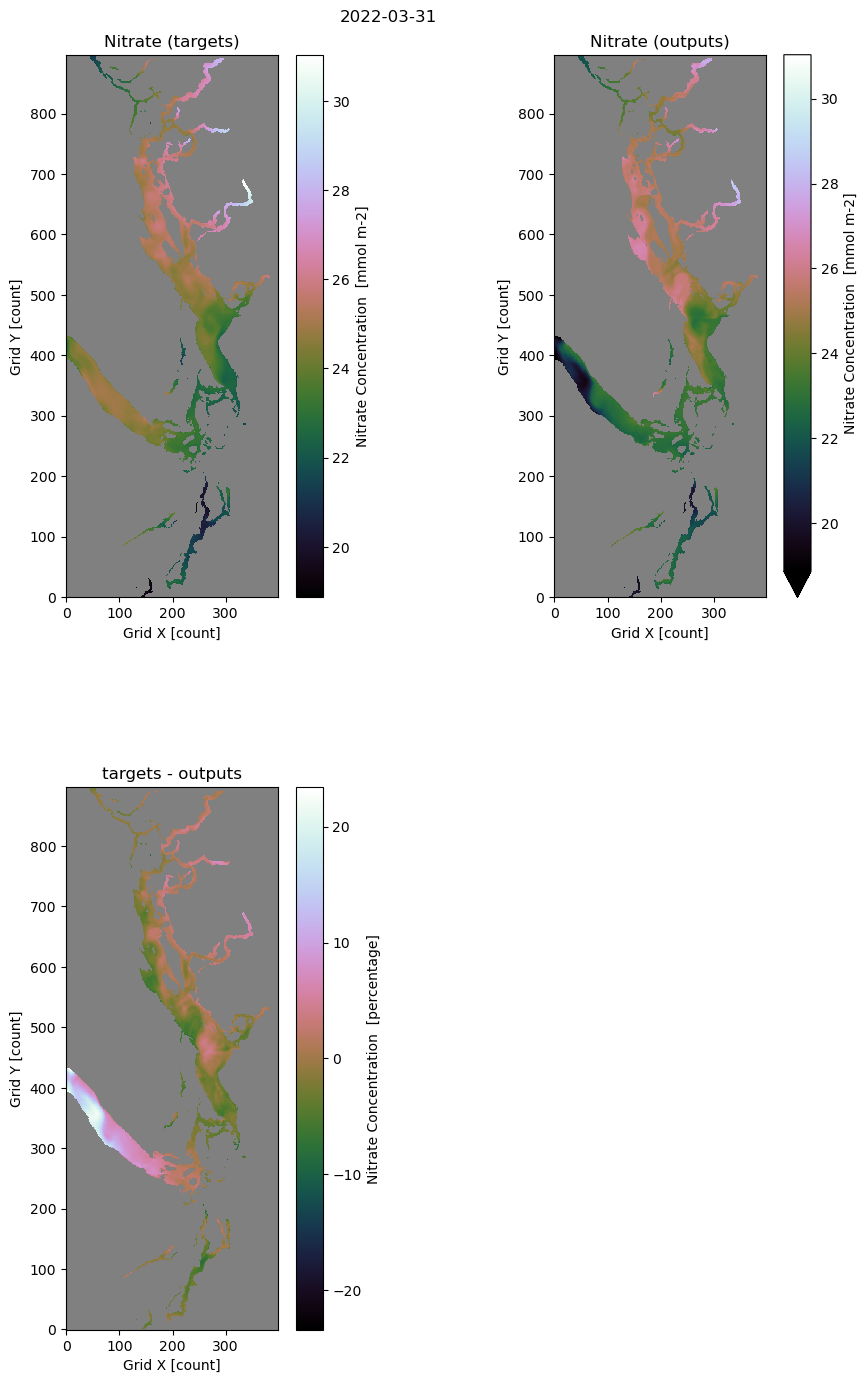

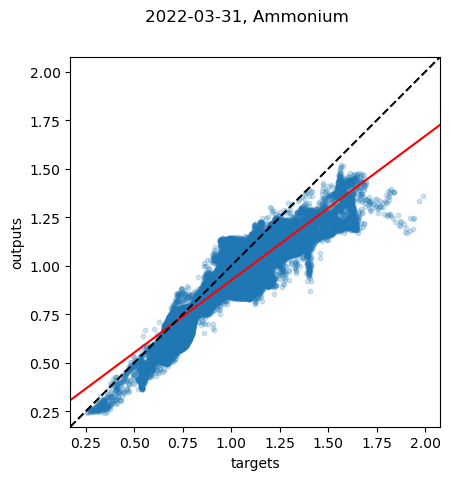

The slope of the best fitting line is  0.745
The correlation coefficient is: 0.611
 The mean square error is: 0.019


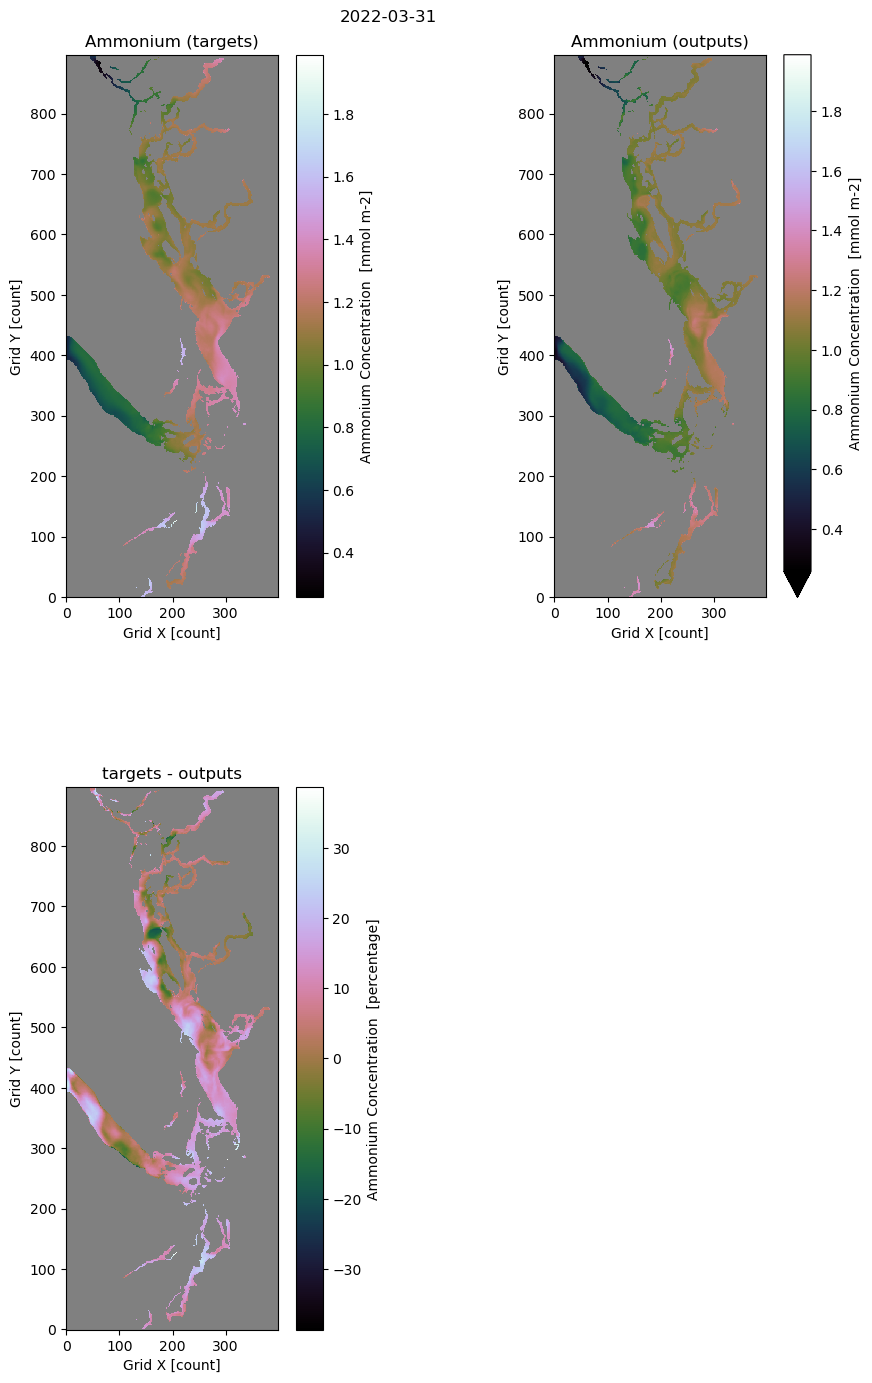

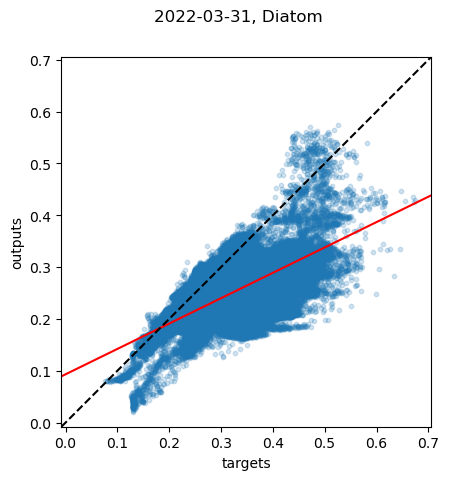

The slope of the best fitting line is  0.489
The correlation coefficient is: -0.355
 The mean square error is: 0.009


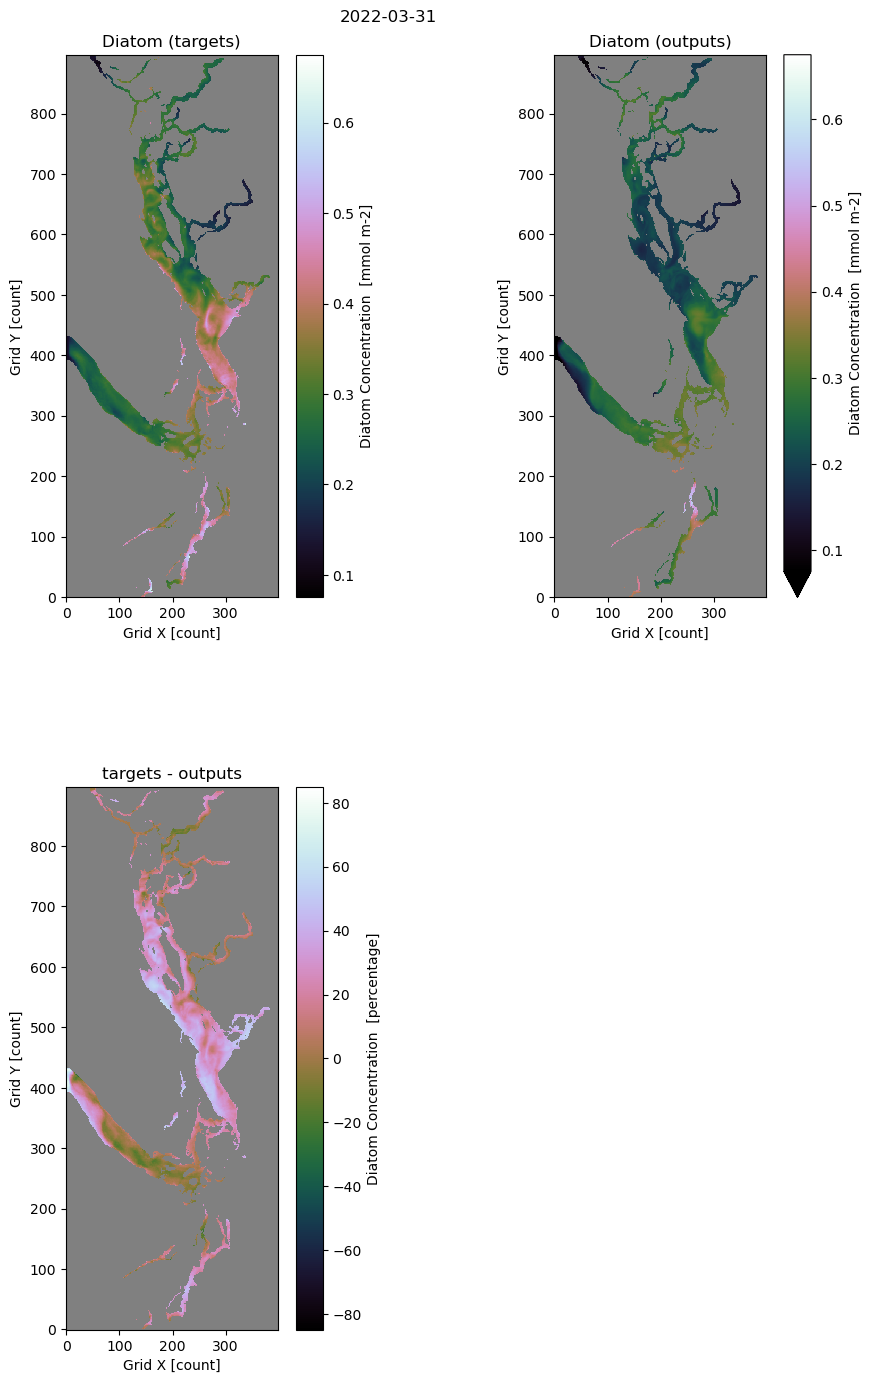

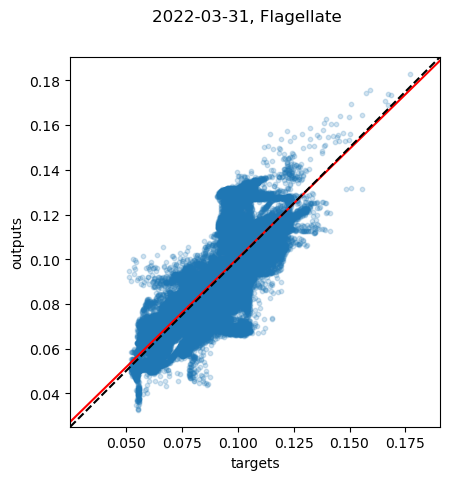

The slope of the best fitting line is  0.977
The correlation coefficient is: 0.484
 The mean square error is: 0.0


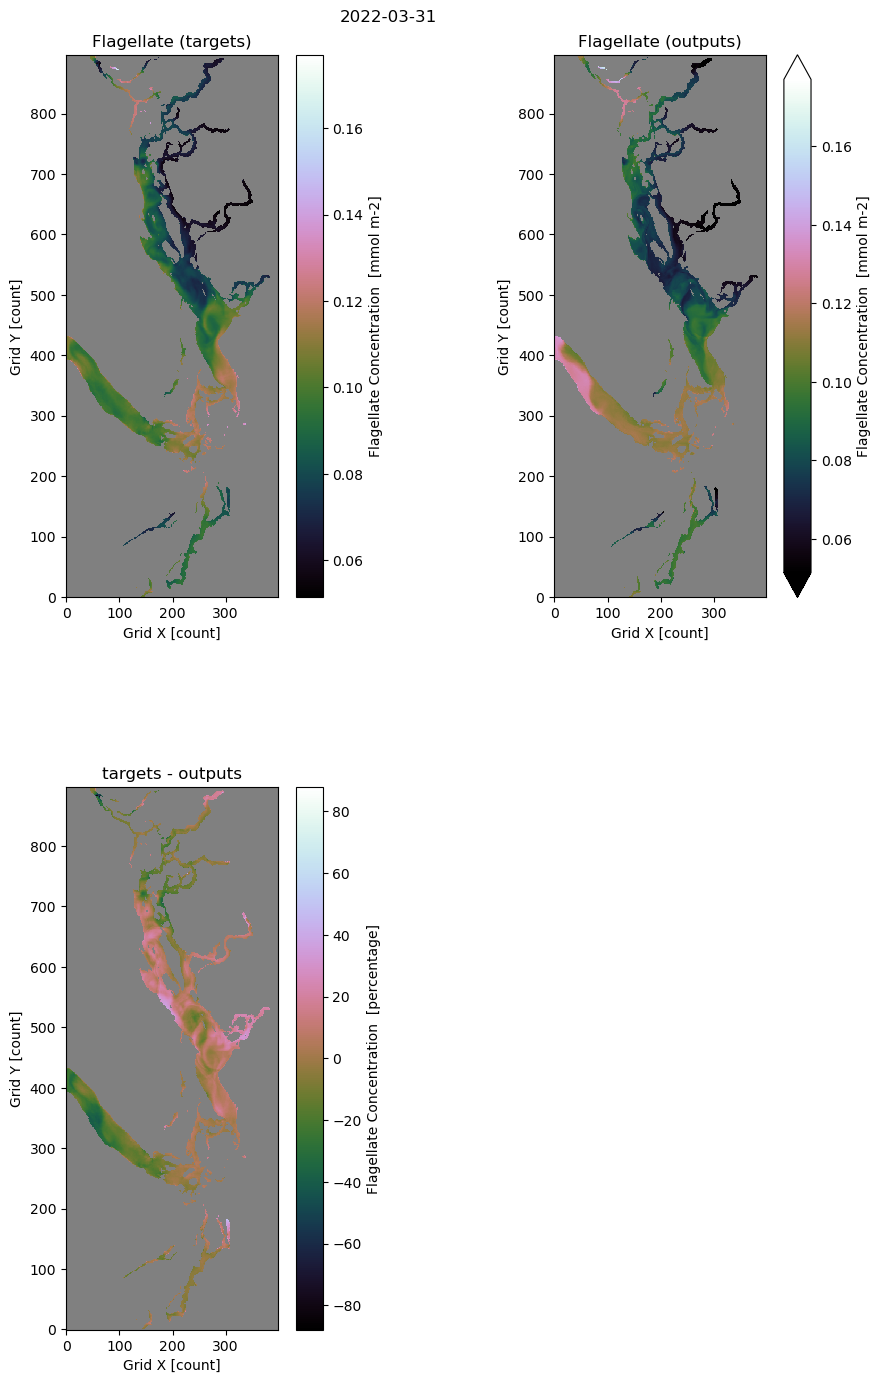

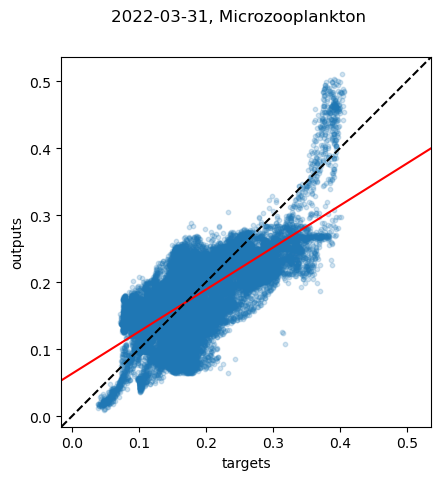

The slope of the best fitting line is  0.628
The correlation coefficient is: 0.46
 The mean square error is: 0.002


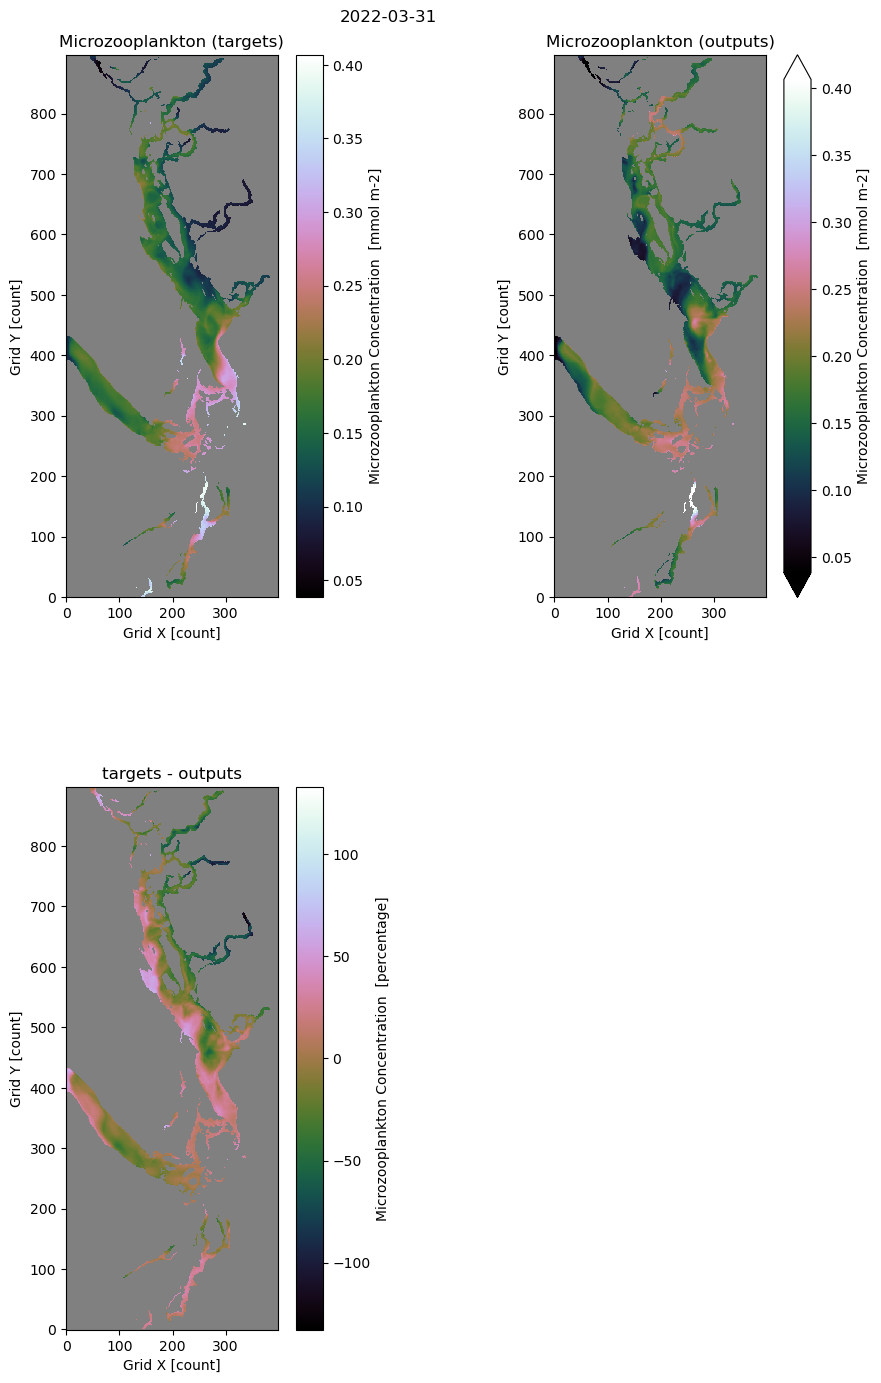

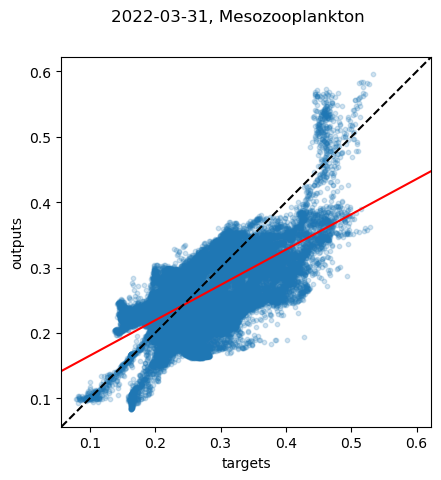

The slope of the best fitting line is  0.541
The correlation coefficient is: 0.385
 The mean square error is: 0.003


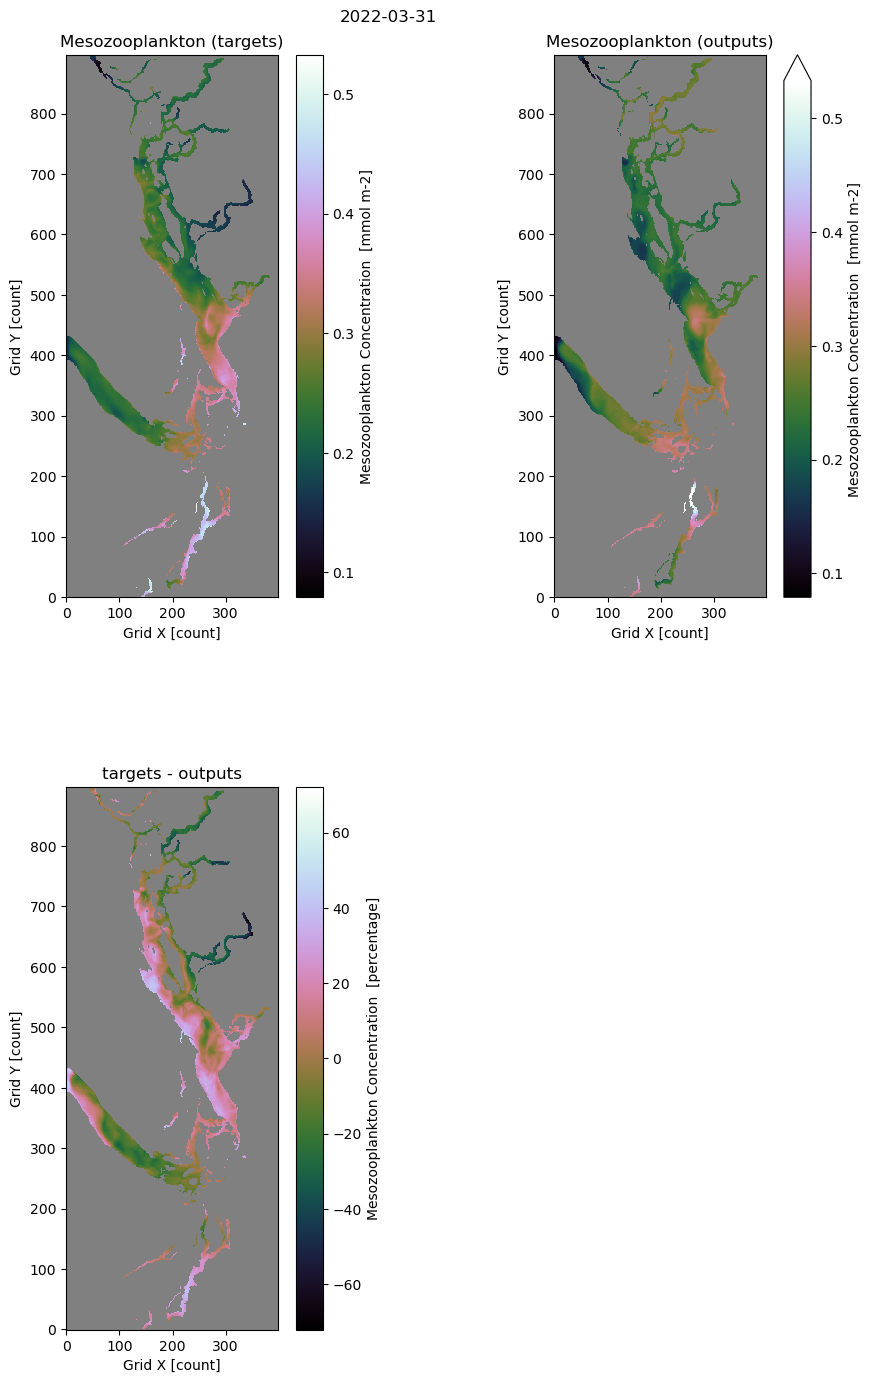

In [35]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i, flag_i, micro_i, meso_i = datasets_preparation()


summary2 (sil_i, 'Silicon', reg_sil)
summary2 (nitr_i, 'Nitrate', reg_nitr)
summary2 (ammo_i, 'Ammonium', reg_ammo)

summary2 (diat_i, 'Diatom', reg_diat)
summary2 (flag_i, 'Flagellate', reg_flag)

summary2 (micro_i, 'Microzooplankton', reg_mic)
summary2 (meso_i, 'Mesozooplankton', reg_mes)
